In [1]:
#Step1 - Create a normalized database (3NF).

In [3]:
import csv
from collections import defaultdict

# Step 1: Read the dataset from the CSV file
def read_csv(file_path):
    with open(file_path, mode='r', encoding='utf-8') as file:
        csv_reader = csv.DictReader(file)
        data = [row for row in csv_reader]
    return data

# Step 2: Normalize data into 3NF
def normalize_data(data):
    # Extract unique cryptocurrencies
    crypto_table = {}
    crypto_id = 1
    for row in data:
        name_symbol_key = (row['Name'], row['Symbol'])
        if name_symbol_key not in crypto_table:
            crypto_table[name_symbol_key] = crypto_id
            crypto_id += 1

    # Create normalized DailyPrices table
    daily_prices_table = []
    for row in data:
        name_symbol_key = (row['Name'], row['Symbol'])
        daily_prices_table.append({
            'Crypto_ID': crypto_table[name_symbol_key],
            'Date': row['Date'],
            'High': row['High'],
            'Low': row['Low'],
            'Open': row['Open'],
            'Close': row['Close'],
            'Volume': row['Volume'],
            'Marketcap': row['Marketcap']
        })

    # Convert crypto_table to a list of dictionaries
    crypto_table_list = [{'Crypto_ID': cid, 'Name': key[0], 'Symbol': key[1]} for key, cid in crypto_table.items()]

    return crypto_table_list, daily_prices_table

# Step 3: Write normalized tables to CSV files
def write_csv(file_path, data, fieldnames):
    with open(file_path, mode='w', encoding='utf-8', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(data)

# Main function to execute normalization
if __name__ == "__main__":
    # Load raw data from the CSV file
    raw_data = read_csv('coin_Bitcoin.csv')

    # Normalize the data into 3NF tables
    crypto_table, daily_prices_table = normalize_data(raw_data)

    # Write the normalized tables to CSV files
    write_csv('Crypto.csv', crypto_table, ['Crypto_ID', 'Name', 'Symbol'])
    write_csv('DailyPrices.csv', daily_prices_table, ['Crypto_ID', 'Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Marketcap'])

    print("Normalization completed. Tables saved as Crypto.csv and DailyPrices.csv.")


Normalization completed. Tables saved as Crypto.csv and DailyPrices.csv.


In [5]:
#Step2 - Write SQL join statement to fetch data from the database and into Pandas DataFrame.

In [7]:
import sqlite3
import csv

# Step 1: Connect to SQLite database
connection = sqlite3.connect('bitcoin_data.db')
cursor = connection.cursor()

# Step 2: Create tables
cursor.execute('''
CREATE TABLE IF NOT EXISTS Crypto (
    Crypto_ID INTEGER PRIMARY KEY,
    Name TEXT NOT NULL,
    Symbol TEXT NOT NULL
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS DailyPrices (
    Price_ID INTEGER PRIMARY KEY AUTOINCREMENT,
    Crypto_ID INTEGER NOT NULL,
    Date TEXT NOT NULL,
    High REAL,
    Low REAL,
    Open REAL,
    Close REAL,
    Volume REAL,
    Marketcap REAL,
    FOREIGN KEY (Crypto_ID) REFERENCES Crypto(Crypto_ID)
)
''')

# Step 3: Insert data into Crypto table
crypto_data = [('Bitcoin', 'BTC')]  # Add more cryptocurrencies if needed
cursor.executemany('INSERT INTO Crypto (Name, Symbol) VALUES (?, ?)', crypto_data)

# Step 4: Insert data into DailyPrices table from CSV
with open('coin_Bitcoin.csv', 'r') as file:
    reader = csv.DictReader(file)
    crypto_id = 1  # Assuming Bitcoin has Crypto_ID = 1
    daily_prices_data = [
        (crypto_id, row['Date'], row['High'], row['Low'], row['Open'], row['Close'], row['Volume'], row['Marketcap'])
        for row in reader
    ]
cursor.executemany('''
INSERT INTO DailyPrices (Crypto_ID, Date, High, Low, Open, Close, Volume, Marketcap)
VALUES (?, ?, ?, ?, ?, ?, ?, ?)
''', daily_prices_data)

# Commit changes and close connection
connection.commit()
connection.close()

print("Data imported successfully.")


Data imported successfully.


In [9]:
import pandas as pd

# Load the CSV file into a DataFrame
file_path = 'coin_Bitcoin.csv'  # Replace with your file path
df = pd.read_csv(file_path)

# Display the data types of each column
print(df.dtypes)


SNo            int64
Name          object
Symbol        object
Date          object
High         float64
Low          float64
Open         float64
Close        float64
Volume       float64
Marketcap    float64
dtype: object


In [11]:
#Step3 - Explore the data to determine if you need to stratify it by some attribute when doing train/test split. Perform the train/test split.

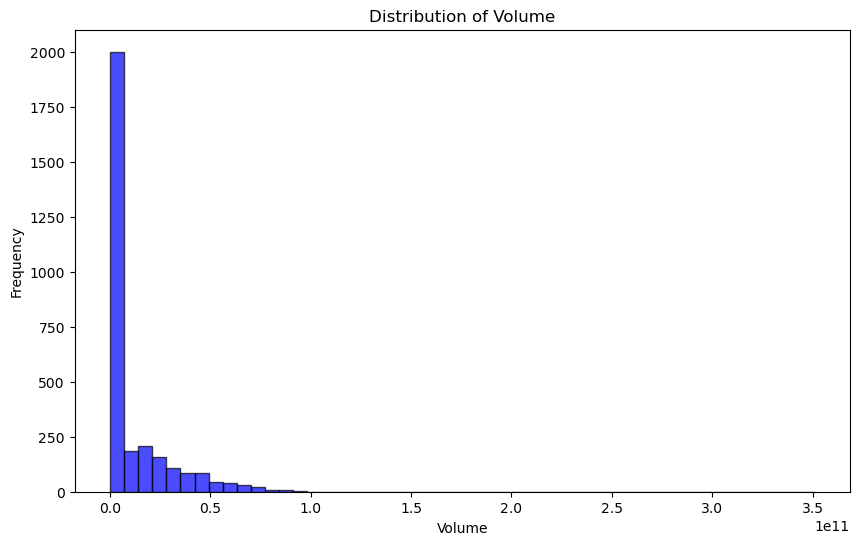

Unique Volume values: 2750
Descriptive statistics for Volume:
 count    2.991000e+03
mean     1.090633e+10
std      1.888895e+10
min      0.000000e+00
25%      3.036725e+07
50%      9.460360e+08
75%      1.592015e+10
max      3.509679e+11
Name: Volume, dtype: float64
Bin counts:
 Volume
0    2664
1     283
2      39
3       4
9       1
Name: count, dtype: int64
Some bins have fewer than 2 samples. Skipping stratification.
Training set size: 2392
Test set size: 599


In [13]:
import sqlite3
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Step 1: Load data from SQLite database
connection = sqlite3.connect('bitcoin_data.db')
query = "SELECT * FROM DailyPrices"
df = pd.read_sql_query(query, connection)
connection.close()

# Step 2: Explore data distribution
# Plot the distribution of 'Volume' to check for skewness or imbalance
plt.figure(figsize=(10, 6))
plt.hist(df['Volume'], bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.show()

# Step 3: Handle potential issues with stratification
# Check the unique values and bin counts for 'Volume'
print("Unique Volume values:", df['Volume'].nunique())
print("Descriptive statistics for Volume:\n", df['Volume'].describe())

# Create bins for stratification (adjust number of bins if necessary)
volume_bins = pd.cut(df['Volume'], bins=10, labels=False)  # Use 10 bins instead of 5

# Check bin counts to ensure no bin has fewer than 2 samples
bin_counts = pd.Series(volume_bins).value_counts()
print("Bin counts:\n", bin_counts)

# If any bin has fewer than 2 samples, skip stratification or adjust bins
if (bin_counts < 2).any():
    print("Some bins have fewer than 2 samples. Skipping stratification.")
    volume_bins = None

# Step 4: Perform train/test split
X = df[['High', 'Low', 'Open', 'Marketcap']]  # Example features
y = df['Close']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,
    stratify=volume_bins if volume_bins is not None else None
)

# Step 5: Output results
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


In [15]:
#Step4 - Explore the data using yprofile and correlation matrix. Make observations about features, distributions, capped values, and missing values. Create a list of data cleanup tasks.

In [17]:
import pandas as pd
from ydata_profiling import ProfileReport

# Load the dataset
file_path = 'coin_Bitcoin.csv'  # Replace with your file path
df = pd.read_csv(file_path)

# Generate a profile report
profile = ProfileReport(df, title="Bitcoin Dataset Profiling Report", explorative=True)

# Save the report as an HTML file
profile.to_file("bitcoin_profiling_report.html")

# Display the report in a Jupyter Notebook (if applicable)
profile.to_notebook_iframe()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

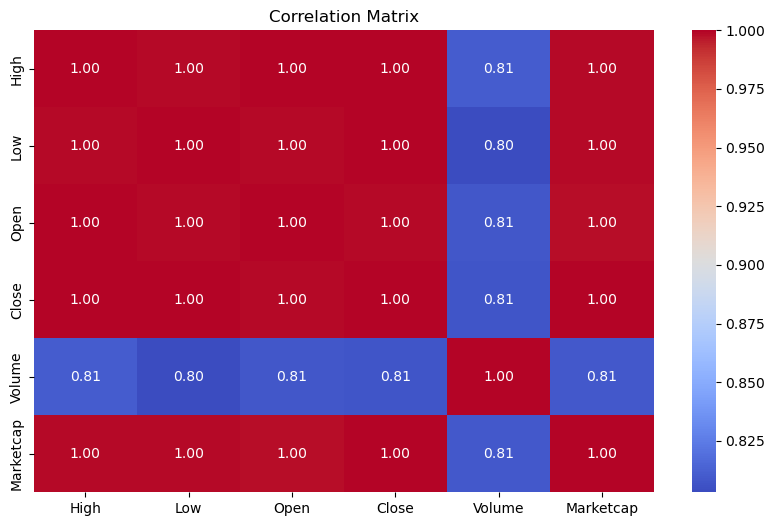

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numerical columns for correlation analysis
numerical_cols = ['High', 'Low', 'Open', 'Close', 'Volume', 'Marketcap']
correlation_matrix = df[numerical_cols].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In [21]:
print("Missing values per column:\n", df.isnull().sum())


Missing values per column:
 SNo          0
Name         0
Symbol       0
Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Marketcap    0
dtype: int64


In [23]:
#Experiment 1 - 

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def preprocess_data(file_path):
    """
    Preprocess the Bitcoin dataset.
    
    Args:
        file_path (str): Path to the dataset CSV file.
    
    Returns:
        X_train, X_test, y_train, y_test: Split and preprocessed data.
        pipeline: Preprocessing pipeline.
    """
    # Load the dataset
    df = pd.read_csv(file_path)

    # Drop irrelevant columns and handle missing values
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.drop(['SNo', 'Name', 'Symbol', 'Date'], axis=1)
    df = df.fillna(df.median())  # Handle missing values

    # Create binary target variable: whether 'Close' > 'Open'
    df['Target'] = (df['Close'] > df['Open']).astype(int)

    # Define features and target variable
    X = df.drop(['Target'], axis=1)
    y = df['Target']

    # Define preprocessing pipeline
    numerical_features = ['High', 'Low', 'Open', 'Volume', 'Marketcap']
    preprocessor = ColumnTransformer(
        transformers=[
            ('standard_scaler', StandardScaler(), numerical_features),
            ('minmax_scaler', MinMaxScaler(), numerical_features),
            ('log_transform', FunctionTransformer(np.log1p), numerical_features)
        ]
    )

    # Create a pipeline with preprocessing only (no model yet)
    pipeline = Pipeline([
        ('preprocessor', preprocessor)
    ])

    # Apply preprocessing to split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test, pipeline


In [27]:
# Example Usage
file_path = 'coin_Bitcoin.csv'  # Replace with your file path
X_train, X_test, y_train, y_test, pipeline = preprocess_data(file_path)

# Inspect the shapes of training and testing datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Inspect a few rows of the training data
print("Sample of X_train:\n", X_train.head())
print("Sample of y_train:\n", y_train.head())


X_train shape: (2392, 6)
X_test shape: (599, 6)
y_train shape: (2392,)
y_test shape: (599,)
Sample of X_train:
               High          Low         Open         Close        Volume  \
1018    383.130005   376.398987   382.114014    379.653992  7.437560e+07   
464     587.486023   583.098022   585.952026    584.653015  1.449790e+07   
1569   4455.970215  3906.179932  4326.990234   4181.930176  3.258050e+09   
678     277.858002   272.565002   276.433014    274.354004  2.206790e+07   
1764  10475.000000  9501.730469  9669.429688  10366.700195  7.287690e+09   

         Marketcap  
1018  5.770551e+09  
464   7.663383e+09  
1569  6.903886e+10  
678   3.818877e+09  
1764  1.750761e+11  
Sample of y_train:
 1018    0
464     0
1569    0
678     0
1764    1
Name: Target, dtype: int64


In [29]:
%pip install -q dagshub mlflow



Note: you may need to restart the kernel to use updated packages.


In [31]:

import dagshub
dagshub.init(repo_owner='sathwickkiranms', repo_name='my-first-repo', mlflow=True)

Accessing as sathwickkiranms

Initialized MLflow to track repo "sathwickkiranms/my-first-repo"

Repository sathwickkiranms/my-first-repo initialized!

In [33]:
import mlflow

with mlflow.start_run():
  # Your training code here...
  mlflow.log_metric('accuracy', 42)
  mlflow.log_param('Param name', 'Value')

🏃 View run bald-hare-452 at: https://dagshub.com/sathwickkiranms/my-first-repo.mlflow/#/experiments/0/runs/b8a9305ab53143f5ba90f77a94013310
🧪 View experiment at: https://dagshub.com/sathwickkiranms/my-first-repo.mlflow/#/experiments/0


In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix
import mlflow
import mlflow.sklearn

# Step 1: Load the dataset
file_path = "coin_Bitcoin.csv"  # Replace with your file path
df = pd.read_csv(file_path)

# Step 2: Data Cleaning and Feature Engineering
# Drop irrelevant columns and handle missing values
df['Date'] = pd.to_datetime(df['Date'])
df = df.drop(['SNo', 'Name', 'Symbol', 'Date'], axis=1)
df = df.fillna(df.median())  # Handle missing values

# Create binary target variable: whether 'Close' > 'Open'
df['Target'] = (df['Close'] > df['Open']).astype(int)

# Define features and target variable
X = df.drop(['Target'], axis=1)
y = df['Target']

# Step 3: Define Preprocessing Pipeline
numerical_features = ['High', 'Low', 'Open', 'Volume', 'Marketcap']
preprocessor = ColumnTransformer(
    transformers=[
        ('standard_scaler', StandardScaler(), numerical_features),
        ('minmax_scaler', MinMaxScaler(), numerical_features),
        ('log_transform', FunctionTransformer(np.log1p), numerical_features)
    ]
)

# Step 4: Create a Pipeline with Logistic Regression Model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Step 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Hyperparameter Tuning using GridSearchCV with Cross-Validation (10 folds)
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2']
}
cv = StratifiedKFold(n_splits=10)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1', n_jobs=-1)

# Fit GridSearchCV to training data
grid_search.fit(X_train, y_train)

# Step 7: Evaluate Best Model on Test Set
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
y_pred = best_model.predict(X_test)

f1 = f1_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Step 8: Log Results to MLFlow on DagsHub
mlflow.set_tracking_uri("https://dagshub.com/sathwickkiranms/my-first-repo.mlflow")  # Replace with your DagsHub repo URI
mlflow.set_experiment("Bitcoin Logistic Regression Experiment")

with mlflow.start_run():
    # Log metrics
    mlflow.log_metric("F1-score", f1)
    mlflow.log_metric("True Positives", tp)
    mlflow.log_metric("True Negatives", tn)
    mlflow.log_metric("False Positives", fp)
    mlflow.log_metric("False Negatives", fn)

    # Log parameters and model to MLFlow
    mlflow.log_params(best_params)
    mlflow.sklearn.log_model(best_model, "model")

print(f"Best Parameters: {best_params}")
print(f"F1 Score on Test Set: {f1}")
print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")


/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the n

🏃 View run unruly-kite-618 at: https://dagshub.com/sathwickkiranms/my-first-repo.mlflow/#/experiments/1/runs/c6e7cee68f8146b3b920bdf3be9b7c80
🧪 View experiment at: https://dagshub.com/sathwickkiranms/my-first-repo.mlflow/#/experiments/1
Best Parameters: {'classifier__C': 10, 'classifier__penalty': 'l2'}
F1 Score on Test Set: 0.860431654676259
Confusion Matrix: TP=299, TN=203, FP=80, FN=17


In [36]:
#Experiment2 - 

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import mlflow
import mlflow.sklearn

# Step 1: Load the dataset
file_path = "coin_Bitcoin.csv"  # Replace with your file path
df = pd.read_csv(file_path)

# Step 2: Data Cleaning and Feature Engineering
# Drop irrelevant columns and handle missing values
df['Date'] = pd.to_datetime(df['Date'])
df = df.drop(['SNo', 'Name', 'Symbol', 'Date'], axis=1)
df = df.fillna(df.median())  # Handle missing values

# Create binary target variable: whether 'Close' > 'Open'
df['Target'] = (df['Close'] > df['Open']).astype(int)

# Define features and target variable
X = df.drop(['Target'], axis=1)
y = df['Target']

# Step 3: Define Preprocessing Pipeline
numerical_features = ['High', 'Low', 'Open', 'Volume', 'Marketcap']
preprocessor = ColumnTransformer(
    transformers=[
        ('standard_scaler', StandardScaler(), numerical_features),
        ('minmax_scaler', MinMaxScaler(), numerical_features),
        ('log_transform', FunctionTransformer(np.log1p), numerical_features)
    ]
)

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Define Classifiers to Evaluate
classifiers = {
    "LogisticRegression": LogisticRegression(solver='liblinear'),
    "RidgeClassifier": RidgeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBClassifier": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Step 6: Set Up MLFlow for Logging Results to DagsHub
mlflow.set_tracking_uri("https://dagshub.com/sathwickkiranms/my-first-repo.mlflow")  # Replace with your DagsHub repo URI
mlflow.set_experiment("Bitcoin Classification Experiment")

# Step 7: Train Each Classifier and Log Results to MLFlow
for name, classifier in classifiers.items():
    with mlflow.start_run(run_name=name):
        # Create a pipeline with preprocessing and the classifier
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ])
        
        # Cross-validation (3-fold)
        skf = StratifiedKFold(n_splits=3)
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='f1')
        
        # Train the model on the full training set
        pipeline.fit(X_train, y_train)
        
        # Evaluate on the test set
        y_pred = pipeline.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        
        # Log metrics to MLFlow
        mlflow.log_metric("F1-score", f1)
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("True Positives", tp)
        mlflow.log_metric("True Negatives", tn)
        mlflow.log_metric("False Positives", fp)
        mlflow.log_metric("False Negatives", fn)

        # Log cross-validation results (mean and std of F1 scores)
        mlflow.log_metric("CV_F1_Mean", np.mean(cv_scores))
        mlflow.log_metric("CV_F1_Std", np.std(cv_scores))
        
        # Log the model to MLFlow
        mlflow.sklearn.log_model(pipeline, "model")
        
        print(f"{name} - F1 Score: {f1}, Accuracy: {accuracy}, CV F1 Mean: {np.mean(cv_scores)}")



2024/12/21 00:47:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LogisticRegression - F1 Score: 0.7843631778058008, Accuracy: 0.7145242070116862, CV F1 Mean: 0.7765723617704051
🏃 View run LogisticRegression at: https://dagshub.com/sathwickkiranms/my-first-repo.mlflow/#/experiments/2/runs/76024d0e02e34a0abd86ffe2cf31a2ce
🧪 View experiment at: https://dagshub.com/sathwickkiranms/my-first-repo.mlflow/#/experiments/2


2024/12/21 00:47:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RidgeClassifier - F1 Score: 0.7943661971830986, Accuracy: 0.7562604340567612, CV F1 Mean: 0.794656557801607
🏃 View run RidgeClassifier at: https://dagshub.com/sathwickkiranms/my-first-repo.mlflow/#/experiments/2/runs/5d05f32966a24d768bbb3fadfdb5c50f
🧪 View experiment at: https://dagshub.com/sathwickkiranms/my-first-repo.mlflow/#/experiments/2


2024/12/21 00:47:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RandomForestClassifier - F1 Score: 0.7142857142857143, Accuracy: 0.6861435726210351, CV F1 Mean: 0.7377584388349114
🏃 View run RandomForestClassifier at: https://dagshub.com/sathwickkiranms/my-first-repo.mlflow/#/experiments/2/runs/e831809f9c17424bab50e43a606cab68
🧪 View experiment at: https://dagshub.com/sathwickkiranms/my-first-repo.mlflow/#/experiments/2


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:47:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:47:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:47:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:47:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2024/12/21 00:47:59 WARNING mlflow.model

XGBClassifier - F1 Score: 0.7346938775510204, Accuracy: 0.6961602671118531, CV F1 Mean: 0.7402005868467253
🏃 View run XGBClassifier at: https://dagshub.com/sathwickkiranms/my-first-repo.mlflow/#/experiments/2/runs/5185935317f6413fa3c158dac4cb5643
🧪 View experiment at: https://dagshub.com/sathwickkiranms/my-first-repo.mlflow/#/experiments/2


In [41]:
#Experiment 3 -

In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import mlflow
import mlflow.sklearn

# Step 1: Load the dataset
file_path = "coin_Bitcoin.csv"  # Replace with your file path
df = pd.read_csv(file_path)

# Step 2: Data Cleaning and Feature Engineering
# Drop irrelevant columns and handle missing values
df['Date'] = pd.to_datetime(df['Date'])
df = df.drop(['SNo', 'Name', 'Symbol', 'Date'], axis=1)
df = df.fillna(df.median())  # Handle missing values

# Feature Engineering: Create new features
df['Daily_Range'] = df['High'] - df['Low']  # Range of daily prices
df['Price_Change'] = df['Close'] - df['Open']  # Absolute price change during the day
df['Price_Change_Percentage'] = (df['Price_Change'] / df['Open']) * 100  # Percentage change

# Create binary target variable: whether 'Close' > 'Open'
df['Target'] = (df['Close'] > df['Open']).astype(int)

# Define features and target variable
X = df.drop(['Target'], axis=1)
y = df['Target']

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Preprocessing Pipeline
numerical_features = ['High', 'Low', 'Open', 'Close', 'Volume', 'Marketcap', 'Daily_Range', 'Price_Change', 'Price_Change_Percentage']
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('classifier', LogisticRegression(solver='liblinear'))  # Logistic Regression model
])

# Step 5: Train the Model and Evaluate Performance
pipeline.fit(X_train[numerical_features], y_train)
y_pred = pipeline.predict(X_test[numerical_features])

f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Step 6: Log Results in MLFlow on DagsHub
mlflow.set_tracking_uri("https://dagshub.com/sathwickkiranms/my-first-repo.mlflow")  # Replace with your DagsHub repo URI
mlflow.set_experiment("Bitcoin Feature Engineering Experiment")

with mlflow.start_run():
    # Log metrics to MLFlow
    mlflow.log_metric("F1-score", f1)
    mlflow.log_metric("Accuracy", accuracy)
    mlflow.log_metric("True Positives", tp)
    mlflow.log_metric("True Negatives", tn)
    mlflow.log_metric("False Positives", fp)
    mlflow.log_metric("False Negatives", fn)

    # Log model to MLFlow
    mlflow.sklearn.log_model(pipeline, "model")

    # Log feature engineering details as parameters/artifacts
    mlflow.log_param("Feature_Engineering", "Added Daily_Range, Price_Change, Price_Change_Percentage")

print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")


2024/12/21 00:48:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run bald-cub-877 at: https://dagshub.com/sathwickkiranms/my-first-repo.mlflow/#/experiments/3/runs/babd3a03fa5947e285f197e9ac2e5afc
🧪 View experiment at: https://dagshub.com/sathwickkiranms/my-first-repo.mlflow/#/experiments/3
F1 Score: 0.9968354430379747
Accuracy: 0.996661101836394
Confusion Matrix: TP=315, TN=282, FP=1, FN=1


In [45]:
#Experiment 4 -

In [47]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score
import mlflow
import mlflow.sklearn

# Step 1: Load the dataset
file_path = "coin_Bitcoin.csv"  # Replace with your file path
df = pd.read_csv(file_path)

# Step 2: Data Cleaning and Feature Engineering
# Drop irrelevant columns and handle missing values
df['Date'] = pd.to_datetime(df['Date'])
df = df.drop(['SNo', 'Name', 'Symbol', 'Date'], axis=1)
df = df.fillna(df.median())  # Handle missing values

# Create binary target variable: whether 'Close' > 'Open'
df['Target'] = (df['Close'] > df['Open']).astype(int)

# Define features and target variable
X = df.drop(['Target'], axis=1)
y = df['Target']

# Step 3: Correlation Threshold Feature Selection
def correlation_threshold(X, threshold=0.9):
    corr_matrix = X.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    return X.drop(columns=to_drop)

X_corr_filtered = correlation_threshold(X)

# Step 4: Variance Threshold Feature Selection
var_thresh = VarianceThreshold(threshold=0.01)  # Remove low variance features
X_var_filtered = var_thresh.fit_transform(X_corr_filtered)

# Step 5: Feature Importance using Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_var_filtered, y)
feature_importances = rf_model.feature_importances_

# Select top K features based on importance
k_best_features_indices = np.argsort(feature_importances)[-5:]  # Select top 5 features as an example
X_final_selected = X_var_filtered[:, k_best_features_indices]

# Step 6: Train-Test Split with Selected Features
X_train, X_test, y_train, y_test = train_test_split(X_final_selected, y, test_size=0.2, random_state=42)

# Step 7: Model Training with Selected Features (Logistic Regression Example)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))  # Using Random Forest for demonstration
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Step 8: Log Results in MLFlow on DagsHub
mlflow.set_tracking_uri("https://dagshub.com/sathwickkiranms/my-first-repo.mlflow")  # Replace with your DagsHub repo URI
mlflow.set_experiment("Bitcoin Feature Selection Experiment")

with mlflow.start_run():
    # Log metrics to MLFlow
    mlflow.log_metric("F1-score", f1)
    mlflow.log_metric("Accuracy", accuracy)

    # Log details about feature selection steps
    mlflow.log_param("Correlation_Threshold", "Removed features with correlation > 0.9")
    mlflow.log_param("Variance_Threshold", "Removed low variance features (threshold=0.01)")
    mlflow.log_param("Feature_Importance", "Top 5 features selected using Random Forest")

    # Log model to MLFlow
    mlflow.sklearn.log_model(pipeline, "model")

print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")


2024/12/21 00:48:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run intelligent-colt-251 at: https://dagshub.com/sathwickkiranms/my-first-repo.mlflow/#/experiments/4/runs/30772fa220cf4e7a95ebd721d180cdbd
🧪 View experiment at: https://dagshub.com/sathwickkiranms/my-first-repo.mlflow/#/experiments/4
F1 Score: 0.5060975609756098
Accuracy: 0.4590984974958264


In [49]:
#Experiment 5 - 

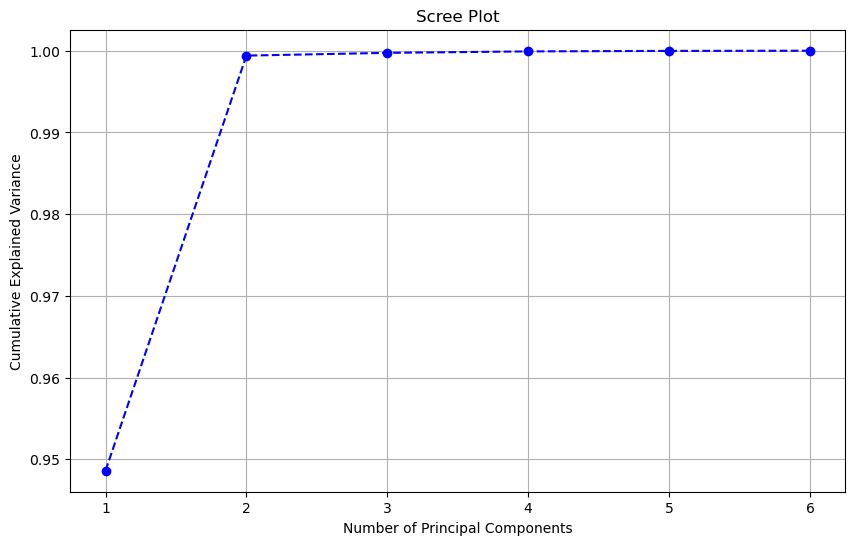

Number of components explaining at least 95% variance: 2


2024/12/21 00:49:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run receptive-yak-453 at: https://dagshub.com/sathwickkiranms/my-first-repo.mlflow/#/experiments/5/runs/037d388d24934df8bb18e19151a2fe39
🧪 View experiment at: https://dagshub.com/sathwickkiranms/my-first-repo.mlflow/#/experiments/5
F1 Score: 0.687842278203724
Accuracy: 0.5242070116861436


In [51]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn

# Step 1: Load the dataset
file_path = "coin_Bitcoin.csv"  # Replace with your file path
df = pd.read_csv(file_path)

# Step 2: Data Cleaning and Feature Engineering
# Drop irrelevant columns and handle missing values
df['Date'] = pd.to_datetime(df['Date'])
df = df.drop(['SNo', 'Name', 'Symbol', 'Date'], axis=1)
df = df.fillna(df.median())  # Handle missing values

# Create binary target variable: whether 'Close' > 'Open'
df['Target'] = (df['Close'] > df['Open']).astype(int)

# Define features and target variable
X = df.drop(['Target'], axis=1)
y = df['Target']

# Step 3: Standardize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Apply PCA for Dimensionality Reduction
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Step 5: Create Scree Plot to Visualize Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid()
plt.savefig("scree_plot.png")  # Save the plot locally for logging in MLFlow
plt.show()

# Select number of components that explain at least 95% of variance
n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Number of components explaining at least 95% variance: {n_components}")

# Reduce dimensions using selected number of components
pca_reduced = PCA(n_components=n_components)
X_reduced = pca_reduced.fit_transform(X_scaled)

# Step 6: Train-Test Split with Reduced Features
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Step 7: Train a Logistic Regression Model (Example)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score

model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Step 8: Log Results in MLFlow on DagsHub
mlflow.set_tracking_uri("https://dagshub.com/sathwickkiranms/my-first-repo.mlflow")  # Replace with your DagsHub repo URI
mlflow.set_experiment("Bitcoin PCA Experiment")

with mlflow.start_run():
    # Log metrics to MLFlow
    mlflow.log_metric("F1-score", f1)
    mlflow.log_metric("Accuracy", accuracy)

    # Log PCA details as parameters/artifacts
    mlflow.log_param("n_components", n_components)
    mlflow.log_artifact("scree_plot.png")  # Log scree plot as an artifact

    # Log model to MLFlow
    mlflow.sklearn.log_model(model, "model")

print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")


In [53]:
#Experiment - 6

In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import mlflow
import mlflow.sklearn

# Step 1: Load the dataset
file_path = "coin_Bitcoin.csv"  # Replace with your file path
df = pd.read_csv(file_path)

# Step 2: Data Cleaning and Feature Engineering
df['Date'] = pd.to_datetime(df['Date'])
df = df.drop(['SNo', 'Name', 'Symbol', 'Date'], axis=1)
df = df.fillna(df.median())  # Handle missing values

# Feature Engineering: Create new features
df['Daily_Range'] = df['High'] - df['Low']
df['Price_Change'] = df['Close'] - df['Open']
df['Price_Change_Percentage'] = (df['Price_Change'] / df['Open']) * 100

# Create binary target variable: whether 'Close' > 'Open'
df['Target'] = (df['Close'] > df['Open']).astype(int)

# Define features and target variable
X = df.drop(['Target'], axis=1)
y = df['Target']

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Preprocessing Pipeline
numerical_features = ['High', 'Low', 'Open', 'Close', 'Volume', 'Marketcap', 'Daily_Range', 'Price_Change', 'Price_Change_Percentage']
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Step 5: Cross-Validation and Model Training
cv = StratifiedKFold(n_splits=5)
f1_scores = []
for train_idx, val_idx in cv.split(X_train[numerical_features], y_train):
    X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    pipeline.fit(X_cv_train[numerical_features], y_cv_train)
    y_cv_pred = pipeline.predict(X_cv_val[numerical_features])
    f1_scores.append(f1_score(y_cv_val, y_cv_pred))

mean_f1_score = np.mean(f1_scores)
std_f1_score = np.std(f1_scores)

# Train final model on the entire training set and evaluate on the test set
pipeline.fit(X_train[numerical_features], y_train)
y_test_pred = pipeline.predict(X_test[numerical_features])

f1_test = f1_score(y_test, y_test_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

# Step 6: Log Results in MLFlow on DagsHub
mlflow.set_tracking_uri("https://dagshub.com/sathwickkiranms/my-first-repo.mlflow")  # Replace with your DagsHub repo URI
mlflow.set_experiment("Custom Bitcoin Experiment")

with mlflow.start_run():
    # Log metrics to MLFlow (valid metric names without invalid characters)
    mlflow.log_metric("F1_score_Test", f1_test)
    mlflow.log_metric("Accuracy_Test", accuracy_test)
    mlflow.log_metric("Mean_F1_score_CV", mean_f1_score)
    mlflow.log_metric("Std_F1_score_CV", std_f1_score)
    mlflow.log_metric("True_Positives", tp)
    mlflow.log_metric("True_Negatives", tn)
    mlflow.log_metric("False_Positives", fp)
    mlflow.log_metric("False_Negatives", fn)

    # Log parameters and feature engineering details
    mlflow.log_param("Feature_Engineering", "Daily_Range, Price_Change, Price_Change_Percentage")
    
    # Log model to MLFlow
    mlflow.sklearn.log_model(pipeline, "model")

print(f"F1 Score (Test): {f1_test}")
print(f"Accuracy (Test): {accuracy_test}")
print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")


2024/12/21 00:49:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run gentle-pug-270 at: https://dagshub.com/sathwickkiranms/my-first-repo.mlflow/#/experiments/6/runs/85fe121dadf74d75b7b72878fd91254f
🧪 View experiment at: https://dagshub.com/sathwickkiranms/my-first-repo.mlflow/#/experiments/6
F1 Score (Test): 0.9968354430379747
Accuracy (Test): 0.996661101836394
Confusion Matrix: TP=315, TN=282, FP=1, FN=1


In [56]:
#Experiment 7 - 

In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import mlflow
import mlflow.sklearn

# Step 1: Load the dataset
file_path = "coin_Bitcoin.csv"  # Replace with your file path
df = pd.read_csv(file_path)

# Step 2: Data Cleaning and Feature Engineering
# Drop irrelevant columns and handle missing values
df['Date'] = pd.to_datetime(df['Date'])
df = df.drop(['SNo', 'Name', 'Symbol'], axis=1)
df = df.fillna(df.median())  # Handle missing values

# Feature Engineering: Create lagged features for time-series analysis
df['Lag_1_Close'] = df['Close'].shift(1)  # Previous day's close price
df['Lag_2_Close'] = df['Close'].shift(2)  # Two days ago close price
df['Lag_1_High'] = df['High'].shift(1)    # Previous day's high price
df['Lag_1_Low'] = df['Low'].shift(1)      # Previous day's low price

# Create binary target variable: whether 'Close' increases from the previous day
df['Target'] = (df['Close'] > df['Lag_1_Close']).astype(int)

# Drop rows with NaN values due to lagged features
df = df.dropna()

# Define features and target variable
X = df[['Lag_1_Close', 'Lag_2_Close', 'Lag_1_High', 'Lag_1_Low', 'Volume', 'Marketcap']]
y = df['Target']

# Step 3: Train-Test Split for Time-Series Data (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 4: Train Random Forest Classifier with TimeSeriesSplit Cross-Validation
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Use TimeSeriesSplit for cross-validation (e.g., 5 splits)
tscv = TimeSeriesSplit(n_splits=5)
f1_scores = []
for train_idx, val_idx in tscv.split(X_train):
    X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    model.fit(X_cv_train, y_cv_train)
    y_cv_pred = model.predict(X_cv_val)
    f1_scores.append(f1_score(y_cv_val, y_cv_pred))

mean_f1_score = np.mean(f1_scores)
std_f1_score = np.std(f1_scores)

# Train final model on the entire training set and evaluate on the test set
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

f1_test = f1_score(y_test, y_test_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

# Step 5: Log Results in MLFlow on DagsHub
mlflow.set_tracking_uri("https://dagshub.com/sathwickkiranms/my-first-repo.mlflow")  # Replace with your DagsHub repo URI
mlflow.set_experiment("Bitcoin Time-Series Experiment")

with mlflow.start_run():
    # Log metrics to MLFlow
    mlflow.log_metric("F1_score_Test", f1_test)
    mlflow.log_metric("Accuracy_Test", accuracy_test)
    mlflow.log_metric("Mean_F1_score_CV", mean_f1_score)
    mlflow.log_metric("Std_F1_score_CV", std_f1_score)
    mlflow.log_metric("True_Positives", tp)
    mlflow.log_metric("True_Negatives", tn)
    mlflow.log_metric("False_Positives", fp)
    mlflow.log_metric("False_Negatives", fn)

    # Log parameters and feature engineering details
    mlflow.log_param("Feature_Engineering", "Lagged features (Lag_1_Close, Lag_2_Close, Lag_1_High, Lag_1_Low)")
    
    # Log model to MLFlow
    mlflow.sklearn.log_model(model, "model")

print(f"F1 Score (Test): {f1_test}")
print(f"Accuracy (Test): {accuracy_test}")
print(f"Confusion Matrix: TP={tp}, TN={tn}, FP={fp}, FN={fn}")


2024/12/21 00:49:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run illustrious-moth-917 at: https://dagshub.com/sathwickkiranms/my-first-repo.mlflow/#/experiments/7/runs/ab8a52dafe05480fbaa62325f8cee527
🧪 View experiment at: https://dagshub.com/sathwickkiranms/my-first-repo.mlflow/#/experiments/7
F1 Score (Test): 0.5911179173047473
Accuracy (Test): 0.5535117056856187
Confusion Matrix: TP=193, TN=138, FP=140, FN=127


In [61]:
#Step 8 - 

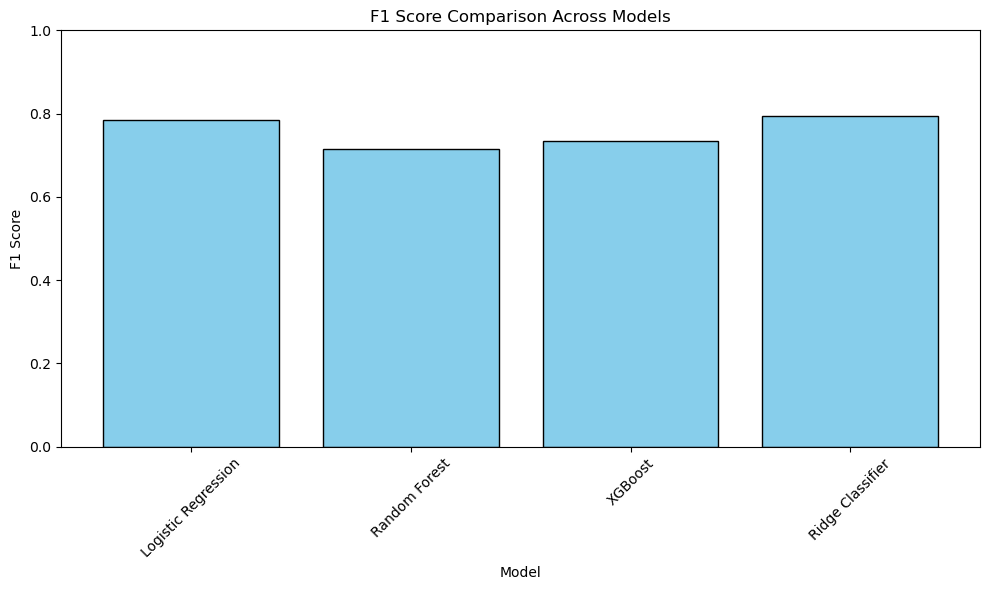

In [63]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Manually define the F1-scores and corresponding models
# Replace these values with the actual F1-scores from your experiments
data = {
    "Model": ["Logistic Regression", "Random Forest", "XGBoost", "Ridge Classifier"],
    "F1 Score": [ 0.7843631778058008, 0.7142857142857143, 0.7346938775510204 , 0.7943661971830986]  # Replace with your actual F1-scores
}

# Step 2: Create a DataFrame for visualization
results_df = pd.DataFrame(data)

# Step 3: Plot the F1-scores for comparison
plt.figure(figsize=(10, 6))
plt.bar(results_df["Model"], results_df["F1 Score"], color="skyblue", edgecolor="black")
plt.xlabel("Model")
plt.ylabel("F1 Score")
plt.title("F1 Score Comparison Across Models")
plt.ylim(0, 1)  # F1-score ranges from 0 to 1
plt.xticks(rotation=45)
plt.tight_layout()

# Step 4: Save and show the plot
plt.savefig("f1_score_comparison_manual.png")  # Save the plot locally
plt.show()


In [65]:
#Saving final model using joblib.

In [67]:
import joblib

# Save the final trained model
joblib.dump(model, "bitcoin_random_forest_model.joblib")
print("Model saved as 'bitcoin_random_forest_model.joblib'.")


Model saved as 'bitcoin_random_forest_model.joblib'.


In [69]:
from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import numpy as np

# Load the saved model
model = joblib.load("bitcoin_random_forest_model.joblib")

# Initialize the FastAPI app
app = FastAPI()

# Define the input data model
class InputData(BaseModel):
    Lag_1_Close: float
    Lag_2_Close: float
    Lag_1_High: float
    Lag_1_Low: float
    Volume: float
    Marketcap: float

# Define the prediction endpoint
@app.post("/predict")
def predict(data: InputData):
    # Prepare the input data for prediction
    input_features = np.array([[data.Lag_1_Close, data.Lag_2_Close, data.Lag_1_High, 
                                data.Lag_1_Low, data.Volume, data.Marketcap]])
    
    # Make the prediction
    prediction = model.predict(input_features)
    
    return {"prediction": int(prediction[0])}


In [71]:
!pip install streamlit
!pip install streamlit requests


In [73]:
import streamlit as st
import requests

# URL of the locally running FastAPI model
api_url = "http://127.0.0.1:8000/predict/"  # This is where FastAPI is running

# Streamlit UI
st.title("Real-time Classification with FastAPI Model")

# Get user input for the model's features
feature1 = st.number_input("Feature 1", min_value=0.0, max_value=100.0, step=0.1)
feature2 = st.number_input("Feature 2", min_value=0.0, max_value=100.0, step=0.1)
feature3 = st.number_input("Feature 3", min_value=0.0, max_value=100.0, step=0.1)
feature4 = st.number_input("Feature 4", min_value=0.0, max_value=100.0, step=0.1)

# Button to make the prediction
if st.button("Predict"):
    # Prepare the input data as a dictionary
    data = {
        "feature1": feature1,
        "feature2": feature2,
        "feature3": feature3,
        "feature4": feature4
    }
    
    # Send a POST request to the FastAPI model
    response = requests.post(api_url, json=data)

    # Check if the request was successful
    if response.status_code == 200:
        prediction = response.json()["prediction"]
        st.write(f"The model prediction is: {prediction}")
    else:
        st.write("Error: Unable to get a response from the model")


2024-12-21 00:50:35.516 
  command:

    streamlit run /opt/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py [ARGUMENTS]
2024-12-21 00:50:35.517 Session state does not function when running a script without `streamlit run`
